In [2]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [41]:
N = 100 #number of nodes
M = 40 # number of communities 
G = nx.random_partition_graph([int(N/M)]*M,1,0.0)

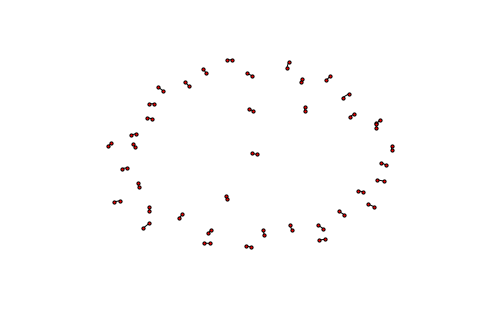

In [42]:
nx.draw(G, node_size = 10)

In [4]:
node2group = np.empty([N])
partlist = list(G.graph['partition']);
for p in range(M):
    for node in partlist[p]:
        node2group[node] = int(p)
node2group = np.asarray(node2group, dtype = int)

C = nx.Graph()
nodeset = set(range(N))
while len(nodeset) > 0:
    n  = np.random.choice(list(nodeset), 1, replace = False)[0]
    c = node2group[n]
    for neigh in G.neighbors(n):
        c_n = node2group[neigh]
        if c_n != c:
            C.add_edge(c, c_n)
    nodeset = nodeset - {n}

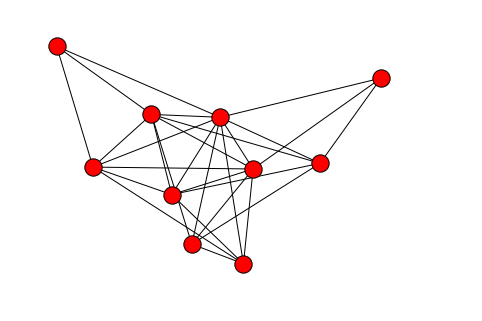

In [5]:
pos = nx.spring_layout(C)
nx.draw(C, pos=pos)

In [27]:
trialtime = 100
#infection = 0.5
trialN = 1000
steps = 50
finesse = 0.2
nswap = 10
infection  = 0.2
infection_thresh = 0.15

infectionsize = np.zeros([steps, trialtime])
neighboursize = np.zeros([steps, trialtime])
infected_neighbours = np.zeros([steps, trialtime])
infection_c_size = np.zeros([steps, trialtime])

'''
control_infectionsize = np.zeros([steps, trialtime])
control_neighboursize = np.zeros([steps, trialtime])
control_infected_neighbours = np.zeros([steps, trialtime])
'''
for trialnumber in range(trialN):
    #print(trialnumber)
    for s in range(1,steps):
        #print(s)
        Gtemp = G.copy()
        infected_nodes = set(np.random.choice(range(N), int(N*infection), replace=False))
        clean_nodes = set(range(N)) - infected_nodes
        infected_coalitions = set()
        infection  = 0.2
        infection_thresh = 0.1

        #nswaps = int(s*finesse *N/M)
        nswaps = s
        for i in range(nswap):
            [c1, c2] = np.random.choice(range(M), 2, replace=False)
            n1 = np.random.choice(list(Gtemp.graph['partition'][c1] ) ,1, replace=False)[0]
            n2 = np.random.choice(list(Gtemp.graph['partition'][c2] ) ,1, replace=False)[0]

            Gtemp.graph['partition'][c1] = Gtemp.graph['partition'][c1] | {n2}
            Gtemp.graph['partition'][c1] = Gtemp.graph['partition'][c1] - {n1}

            Gtemp.graph['partition'][c2] = Gtemp.graph['partition'][c2] | {n1}
            Gtemp.graph['partition'][c2] = Gtemp.graph['partition'][c2] - {n2}
        node2group = np.empty([N])
        partlist = list(Gtemp.graph['partition']);
        for p in range(M):
            for node in partlist[p]:
                node2group[node] = int(p)
        node2group = np.asarray(node2group, dtype = int)
        C = nx.Graph()
        nodeset = set(range(N))
        while len(nodeset) > 0:
            n  = np.random.choice(list(nodeset), 1, replace = False)[0]
            c = node2group[n]
            for neigh in Gtemp.neighbors(n):
                c_n = node2group[neigh]
                if c_n != c:
                    C.add_edge(c, c_n)
            nodeset = nodeset - {n}
        for t in range(trialtime):

            infectionsize[s][t] = infectionsize[s][t] + len(infected_nodes)/N     
            infection_c_size[s][t] = infection_c_size[s][t] + len(infected_coalitions)/M
            
            if t > 10 and len(infected_nodes)/N  <= 1/N:
                #infection_c_size[s][range(t+1, trialtime)] = 0
                #neighboursize[s][range(t+1, trialtime)] = neighboursize[s][t]
                #infected_neighbours[s][range(t+1, trialtime)] = infected_neighbours[s][t]
                break
            if t > 10 and len(infected_nodes)/N  >= 1- 1/N:
                infectionsize[s][range(t+1, trialtime)] =  infectionsize[s][range(t+1, trialtime)] + 1
                #neighboursize[s][range(t+1, trialtime)] = neighboursize[s][t]
                #infected_neighbours[s][range(t+1, trialtime)] = infected_neighbours[s][t]
                #infection_c_size[s][range(t+1, trialtime)] = 1
                break
            if len(infected_coalitions) == M:
                break
            

            if len(infected_coalitions) ==0:
                coalition = np.random.choice(range(M), 1, replace=False)[0]
            else:
                e = 0
                while e == 0:
                    nodec = np.random.choice(list(infected_coalitions), 1, replace=False)[0]
                    neighset = {c for c in C.neighbors(nodec)}
                    e = len(neighset - infected_coalitions)
                    if e > 0:
                        coalition = np.random.choice(list(neighset) ,1, replace=False)[0]
            



            #node = np.random.choice(range(N), 1, replace=False)[0]
            #coalition = partlist[node2group[node]]


            neighbors = set()
            coal =  Gtemp.graph['partition'][coalition];
            for member in coal:
                neighbors.update({n for n in G.neighbors(member)})

            neighbors =  neighbors - coal
            neighboursize[s][t] = neighboursize[s][t] + len(neighbors)
            infected_neighbours[s][t] = infected_neighbours[s][t] + len(infected_nodes.intersection(neighbors))

            if len(infected_nodes.intersection(neighbors)) >= infection_thresh*len(neighbors) :

                infected_nodes.update(coal)
                infected_coalitions.update({coalition})
                clean_nodes = set(range(N))- infected_nodes


            else :
                clean_nodes.update(coal)
                infected_nodes = set(range(N))- clean_nodes
                if coal in infected_coalitions:
                    infected_coalitions.remove(coal)

infectionsize = infectionsize/trialN
neighboursize = neighboursize/trialN
infected_neighbours = infected_neighbours/trialN
infection_c_size = infection_c_size/trialN


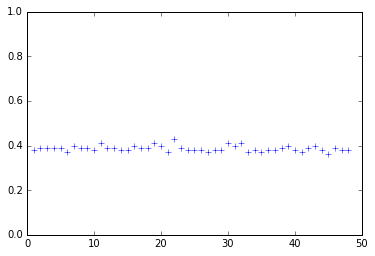

In [32]:

convergence_rate = np.zeros([steps-1])
for s in range(1,steps-1):
    
    time = np.where(infectionsize[s][range(trialtime)]>1- 1/N)[0]
    if len(time) > 0:
        convergence_rate[s] = np.min(time)
    else:
        convergence_rate[s] = trialtime
convergence_rate = convergence_rate/trialtime
plt.plot(range(steps-1), convergence_rate, 'b+')
plt.ylim(0,1)
plt.show()

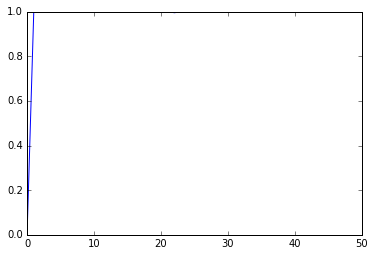

In [37]:
window = trialtime
t = range(window)
i = int(steps/2)
#plt.plot(t, infectionsize[i][t], 'k-',t, infected_neighbours[i][t]/N, 'r-', t, neighboursize[i][t]/N, 'b-')
reverse = infectionsize.T



plt.plot(np.arange(steps), reverse[trialtime-1][range(steps)], 'b-')
#plt.plot(t, coalitionsize[1][t]) 
#plt.plot(coalitionsize[i], neighboursize[i], 'b+')
plt.ylim(0, 1)
plt.show()




In [ ]:
maxneigh = np.empty([50])
for s in range(50):
    maxneigh[s] = np.max(neighboursize[s][range(50)])/N
plt.plot(range(20), maxneigh[range(20)])

In [ ]:
nx.draw(C, node_size = 10)

In [ ]:
G.graph['partition']

In [ ]:
nx.draw(G.subgraph(G.graph['partition'][1]), node_size=10)

In [ ]:
neighboursize[49][range(20)]

In [ ]:
np.min(np.where(infectionsize[2][range(trialtime)]> 1-1/N))

In [38]:
def probconnection(l_out, m, n):
    #return 1-np.exp(-l_out*(m-1))*(2-np.exp(-l_out))**(m-2) 
    return 1-(np.exp(-2*n-(m-2)*l_out)*((2-np.exp(-l_out))**m) *(np.exp(n) - np.exp((m-1)*l_out)+np.exp(m*l_out))**2)/(1-2*np.exp(l_out))**2

In [40]:
def number_of_connections(l_out, m, n):
    #return ((m-2)*(1-np.exp(-l_out))+1)*l_out
    #return ((m-2)*(1-np.exp(-l_out)))*l_out + (1-np.exp(-(n-(m-1)*l_out)))*l_out + (1-np.exp(-l_out))*(n-(m-1)*l_out)
    return np.exp(-n-(1+m)*l_out)*np.exp(m*l_out)*(np.exp(n+l_out)*n - np.exp(m*l_out)*l_out + np.exp(n)*(l_out-n))

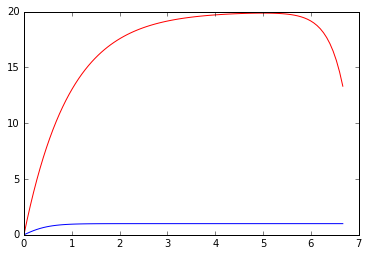

In [128]:
m = 4#number of communities
n = 20 #number of nodes per community
lmax = n/(m-1)
probconnection_theory= probconnection(np.linspace(0,lmax,100),m,n)
number_of_connections_theory = number_of_connections(np.linspace(0,lmax,100),m, n)

plt.plot(np.linspace(0, lmax, 100), probconnection_theory, 'b-')
plt.plot(np.linspace(0, lmax, 100), number_of_connections_theory, 'r-')

In [134]:
sum(number_of_connections_theory>=n-0.2)

15

In [124]:
weightrecord = np.zeros(100)
connectrecord = np.zeros(100)
trialnumber = 100
for t in range(trialnumber):
    for l in range(100):
        lam = l*lmax/99
        watertower = np.random.poisson(lam, (m,m))
        measurement = nx.complete_graph(m, nx.DiGraph())
        for i in range(m):
            for j in range(m):
                if i==j:
                    lin = n-(m-1)*lam
                    #print(lin)
                    w = np.random.poisson(lin)
                    if w > 0:
                        measurement.add_edge(i,j, weight=w)
                else:
                    if watertower[i][j] == 0:
                        measurement.remove_edge(i,j)
                    else: 
                        measurement.add_edge(i,j, weight=watertower[i][j])

        adj_matrix = nx.adjacency_matrix(measurement)

        weight = np.dot(adj_matrix>0, adj_matrix.T).T 
        #secneigh= np.dot(adj_matrix, adj_matrix) + adj_matrix
        secneigh= weight>0
        connectrecord[l] =  connectrecord[l] + secneigh.sum()/m/(m-1) - (secneigh.diagonal()).sum()/m/(m-1)
        weightrecord[l] = weightrecord[l] + weight.sum()/m/(m-1) - (weight.diagonal()).sum()/m/(m-1)

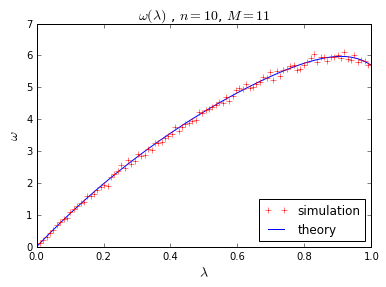

In [125]:
fig = plt.figure()
axes = plt.gca()
#axes.set_ylim([0,n*1.05])
the, = plt.plot(np.linspace(0,lmax,100), number_of_connections(np.linspace(0,lmax,100),m, n), 'b-', label='theory')
sim, = plt.plot(np.linspace(0,lmax,100), weightrecord/trialnumber, 'r+',label='simulation')
titlename = '$\omega(\lambda)$ , $n={}$, $M={}$'.format(n, m)
plt.legend(handles=[sim, the], loc=4)
plt.xlabel('$\lambda$', fontsize=14, color='black')
plt.ylabel('$\omega$', fontsize=14, color='black')
plt.title(titlename, fontsize=14, color='black')
plt.show()
filename = "wl_n{}_m{}.eps".format(n, m)
fig.savefig(filename, format="eps")

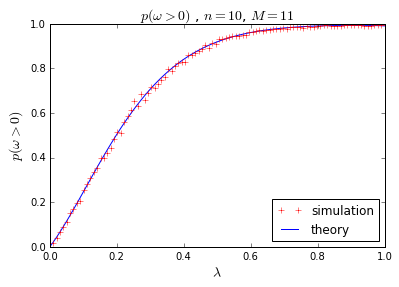

In [126]:
fig = plt.figure()
axes = plt.gca()
axes.set_ylim([0,1])
the, = plt.plot(np.linspace(0,lmax,100), probconnection(np.linspace(0,lmax,100),m,n), 'b-', label='theory')
sim, = plt.plot(np.linspace(0,lmax,100), connectrecord/trialnumber, 'r+', label='simulation')

titlename = '$p(\omega > 0)$ , $n={}$, $M={}$'.format(n, m)
plt.legend(handles=[sim, the], loc=4)
plt.xlabel('$\lambda$', fontsize=14, color='black')
plt.ylabel('$p(\omega >0)$', fontsize=14, color='black')
plt.title(titlename, fontsize=14, color='black')
plt.show()
filename = "p_nonzero_n{}_m{}.eps".format(n, m)
fig.savefig(filename, format="eps")

In [35]:
ans = connectrecord/probconnection(np.linspace(lmax/100,lmax,100),m,n)/trialnumber

In [36]:
np.average(ans[range(1,100)])

0.98162964642892492

In [86]:
np.sum(weightrecord/trialnumber > 41)

0